# Reprojecting solar maps

This tutorial demonstrates how to reproject solar image maps to or from the Solar Orbiter/STIX point of view. The general method is outlined [here](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_different_observers.html). 

Key differences covered by this tutorial are:

- faster reprojection of submaps (in the future will be included in stixpy and/or sunpy)
- determination of Solar Orbiter observer without relying on a SunPy map

Required packages:

- sunpy
- reproject
- astropy
- os

Optional packages:

- stixpy
- heliopy



In [1]:
import sunpy
import sunpy.map
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
%matplotlib inline

## Reproject AIA submap to STIX perspective

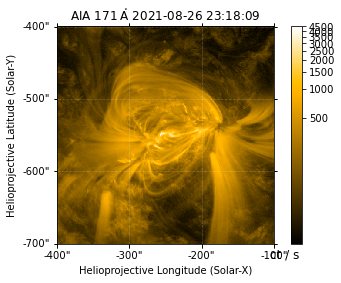

In [2]:
aia_sm=sunpy.map.Map('sample_data/aia_lev1_171a_2021_08_26t23_18_09_35z_image_lev1_cutout.fits') 
aia_sm.peek() #this is the map that will be reprojected

Now we need to determine the Solar Orbiter observer at the desired time. If you have a solar map from the corresponding time, this is simple:  

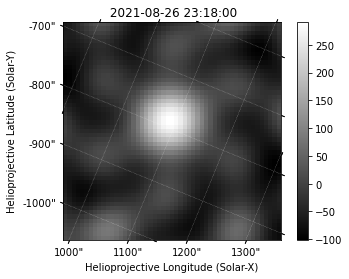

In [10]:
stix_map=sunpy.map.Map('sample_data/stix_image_sci_5450_uid_2108260029_12.0-28.0keV_20210826T231800-20210826T231939_73_full_disk_bp_map.fits')
stix_sm=stix_map.submap(SkyCoord(950*u.arcsec,-950*u.arcsec,frame=stix_map.coordinate_frame),top_right=SkyCoord(1250*u.arcsec,-650*u.arcsec,frame=stix_map.coordinate_frame))
stix_sm.peek() #STIX back projection image

If you run into _ValueError: 'arcsecs' did not parse as unit_ while loading the STIX map, uncomment and run the following line, then try again.

In [4]:
#u.add_enabled_units([u.def_unit("arcsecs",1*u.arcsec)])

If you do not have a solar map at the corresponding time, see instructions for getting trajectory information from the STIX Data Center or SPICE kernel [here](link/to/other/tutorial). Only a reference coordinate with the correct observer is necessary.

### without stixpy

Just like in the SunPy tutorial, you can now use _reproject_to()_ immediately if you choose. Depending on the output size of the data array, this can take more than 30s. Recommended are the following few steps which will make the reprojection process much faster for submaps (it can also help correctly calculate the new extent for full-disk reprojections, in the case that Solar Orbiter is much closer to or farther from the Sun than 1AU). 

In [11]:
def find_reprojected_extent(smap,sobs, swcs=None, full_disk=False):
    """Find extent in NAXIS1 and NAXIS2 of reprojected map
    Inputs:
    smap: sunpy.map.Map
    sobs: SkyCoord reference coordinate
    swcs: astropy.wcs 
    """
    if full_disk:
        rsun_arcsec = int(sunpy.map.solar_angular_radius(sobs).value) #assuming 1":1px scale
        return -rsun_arcsec, rsun_arcsec, -rsun_arcsec, rsun_arcsec

    if not swcs: #make the WCS from observer information
        swcs=WCS(sunpy.map.make_fitswcs_header((1,1),sobs))
        
    # Obtain the pixel locations of the edges of the reprojected map
    edges_pix = np.concatenate(sunpy.map.map_edges(smap)) #what about if off disk? currently doesn't work correctly in that case
    edges_coord = smap.pixel_to_world(edges_pix[:, 0], edges_pix[:, 1])
    new_edges_coord = edges_coord.transform_to(sobs)
    new_edges_xpix, new_edges_ypix = swcs.world_to_pixel(new_edges_coord)

    #check for NaNs...
    if new_edges_xpix[np.isnan(new_edges_xpix)] !=np.array([]) or new_edges_ypix[np.isnan(new_edges_ypix)] !=np.array([]):
        cc=sunpy.map.all_coordinates_from_map(smap).transform_to(sobs)
        on_disk=sunpy.map.coordinate_is_on_solar_disk(cc)
        on_disk_coordinates=cc[on_disk]
        nan_percent=1.-len(on_disk_coordinates)/len(cc.flatten())
        if nan_percent > 0.5:
            warnings.warn(f"Warning - {nan_percent*100:.1f}% of pixels in reprojected map are NaN!") #this won't print all the time so watch out

    # Determine the extent needed - use of nanmax/nanmin means only on-disk coords are considered
    left, right = np.nanmin(new_edges_xpix), np.nanmax(new_edges_xpix)
    bottom, top = np.nanmin(new_edges_ypix), np.nanmax(new_edges_ypix)
    return left, right, bottom, top


In [12]:
def modify_header(smap,sobs, swcs=None, full_disk=False):
    """Modify the header information to be passed to sunpy.map.Map.reproject_to() 
    to contain WCS keywords corresponding to the new location and extent of the reprojected map
    
    Inputs:
    smap: sunpy.map.Map
    sobs: SkyCoord reference coordinate
    swcs: astropy.wcs 
    """
    left, right, bottom, top = find_reprojected_extent(smap, sobs, swcs, full_disk=full_disk)
    # Adjust the CRPIX and NAXIS values
    modified_header = sunpy.map.make_fitswcs_header((1, 1), sobs)
    modified_header['crpix1'] -= left
    modified_header['crpix2'] -= bottom
    modified_header['naxis1'] = int(np.ceil(right - left))
    modified_header['naxis2'] = int(np.ceil(top - bottom))
    return modified_header

In [13]:
stix_obs = stix_sm.reference_coordinate 

In [14]:
%%time
reprojected_aia_header = modify_header(aia_sm, stix_obs)
reprojected_aia = aia_sm.reproject_to(reprojected_aia_header)

/Users/wheatley/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


CPU times: user 701 ms, sys: 109 ms, total: 810 ms
Wall time: 825 ms


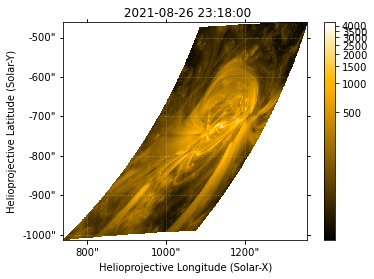

In [15]:
reprojected_aia.peek() # AIA image seen from Solar Orbiter perspective

### with stixpy

In [17]:
import stixcore
from stixpy.vis.map_reprojection import *

In [95]:
stix_obs = get_solo_position(aia_sm) #doesn't work with current version of STIXCore

NameError: name 'Spice' is not defined

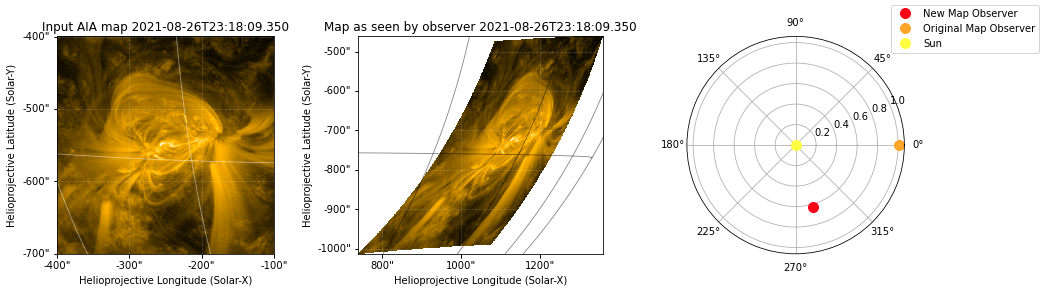

In [18]:
reprojected_aia = reproject_map(aia_sm, stix_obs)
fig = plot_map_reproj(aia_sm,reprojected_aia)

## Reproject STIX submap to AIA perspective

The procedure works similarly in reverse:

In [19]:
aia_obs = aia_sm.reference_coordinate

In [20]:
%%time
reprojected_stix_header = modify_header(stix_sm, aia_obs)
reprojected_stix = stix_sm.reproject_to(reprojected_stix_header)

/Users/wheatley/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


CPU times: user 509 ms, sys: 55.3 ms, total: 564 ms
Wall time: 566 ms


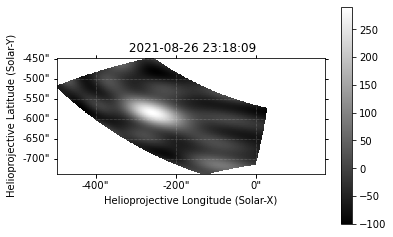

In [21]:
reprojected_stix.peek()

### with stixpy

In [22]:
aia_obs = get_sdo_position(stix_sm)

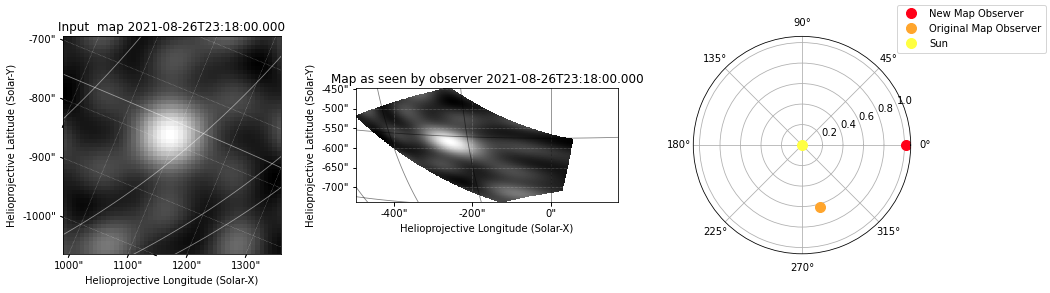

In [23]:
reprojected_stix = reproject_map(stix_sm, aia_obs)
fig = plot_map_reproj(stix_sm,reprojected_stix)

## Plot results as composite map

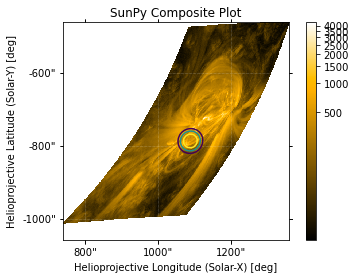

In [25]:
# AIA -> STIX
cmap1=sunpy.map.Map(reprojected_aia, stix_sm,composite=True)
levels = [70,80,90] 
cmap1.set_levels(index=1, levels=levels, percent=True)
cmap1.peek()

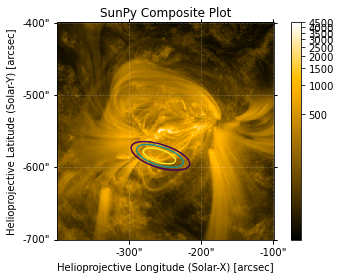

In [27]:
# STIX -> AIA
cmap2=sunpy.map.Map(aia_sm, reprojected_stix.submap(aia_sm.bottom_left_coord,top_right=aia_sm.top_right_coord),composite=True)
levels = [70,80,90] 
cmap2.set_levels(index=1, levels=levels, percent=True)
cmap2.peek()